血的教训:
1. 对mask做插值(rescale,resize),一定且只能在onehot编码上操作

  0%|          | 0/181 [00:00<?, ?it/s]

seg dataset:
1302098 :
1352900 :


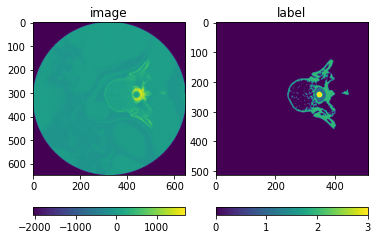

> <ipython-input-1-a5f3a51a4811>(113)covert_h5()
    111         pdb.set_trace()
    112 
--> 113         if not image.shape == seg.shape[:-1]:
    114             error_samples.append(sample_name)
    115             print("error sample(mismatch shape of image and seg):",sample_name)

ipdb> seg.sum(axis=-1).max()
1


In [ ]:
import numpy as np
from glob import glob
from tqdm import tqdm
import h5py
import nrrd
import os
import pandas as pd
from dataset_split import remove_files
import SimpleITK as sitk
from skimage import transform
from collections import Counter
import matplotlib.pyplot as plt

output_size =[128, 128, 64]

def resample_image3D(
    image3D,
    newspacing=[0.3,0.3,3],
    newsize=None,
    method='Linear',):
    """做插值"""
    resample = sitk.ResampleImageFilter()
    if method == 'Linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif method == 'Nearest':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    resample.SetOutputDirection(image3D.GetDirection())
    resample.SetOutputOrigin(image3D.GetOrigin())
    resample.SetOutputSpacing(newspacing)

    if not newsize:
        newsize = np.round(np.array(image3D.GetSize())*np.abs(image3D.GetSpacing())/np.array(newspacing)).astype('int').tolist()

    resample.SetSize(newsize)
    # resample.SetDefaultPixelValue(0)

    newimage = resample.Execute(image3D)
    return newimage

# 数组替换元素
def array_replace(array,olds,news):
    # 不适用于onehot
    #olds:list of old value
    #news:list of new value
    olds = np.array(olds)
    news = np.array(news)
    offset = olds.max()*10
    tmps = olds+offset
    array += offset
    for tmp,new in zip(tmps,news):
        array[array==tmp] = new
    return array

def covert_h5(glob_str, old_replaced, new_replaced):
    """
    备注：不要骨头，骨头合并到背景类别中
    """
    listt = glob(glob_str)
    error_samples = []
    error_samples_origin = []
    stats = pd.DataFrame(columns=['sample_name',
                                  'mean_whole', 
                                  'mean_bg', 
                                  'mean_dura', 
                                  'mean_SC', 
                                  'std_whole',
                                  'std_bg',
                                  'std_dura',
                                  'std_SC',
                                  'old_space0','old_space1','old_space2',
                                  'new_space0','new_space1','new_space2',
                                 ])
    for item in tqdm(listt):
        sample_name = item.split('/')[-2]
        print(sample_name,':')#win系统改为'\\'
        if not sample_name == "1352900":#B809338":#"1756747":#1700637-neck":
            continue

        image = sitk.ReadImage(item)
        label = sitk.ReadImage(item.replace(old_replaced, 'Segmentation-label.nrrd'))
        seg = sitk.ReadImage(item.replace(old_replaced, 'Segmentation.seg.nrrd'))
        
        oldspacing = np.abs(image.GetSpacing())
        newspacing = [0.3, 0.3, 3.0]
#         offset = [int(k) for k in seg.GetMetaData('Segmentation_ReferenceImageExtentOffset').split()]

        label_name = [
            seg.GetMetaData('Segment0_Name'),
            seg.GetMetaData('Segment1_Name'),
            seg.GetMetaData('Segment2_Name') 
            ]#人工标注的类别顺序
        
        # resample( by sitk )
        image = resample_image3D(image,newspacing,method='Linear')
        seg = resample_image3D(seg,newspacing,method='Nearest')
        
        image = sitk.GetArrayFromImage(image).transpose((2,1,0))#tanspose之后才能与sizes匹配
        label = np.round( sitk.GetArrayFromImage(label) ).transpose((2,1,0))#tanspose之后才能与sizes匹配
        seg = sitk.GetArrayFromImage(seg).transpose((2,1,0,3))#tanspose之后才能与sizes匹配
        plot_slice_sample(image,label,np.nonzero(label)[2].max(),item.replace(old_replaced,'slice_sample_origin.png'))
        
        # offset(to align image with seg)
        # first cut (image to label)
        tempL = np.nonzero(label)
        minx, maxx = np.min(tempL[0]), np.max(tempL[0])
        miny, maxy = np.min(tempL[1]), np.max(tempL[1])
        minz, maxz = np.min(tempL[2]), np.max(tempL[2])
        image = image[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        
        import pdb
        pdb.set_trace()
        
        if not image.shape == seg.shape[:-1]:
            error_samples.append(sample_name)
            print("error sample(mismatch shape of image and seg):",sample_name)
            continue

        if not seg.sum(axis=-1).max()==1:
            # label onehot encoder可以解决这个问题
            error_samples.append(sample_name)
            print("error sample(some pixels in seg are multi-category at the same time):",sample_name)
            continue
        
        # rescale
        ratio = (np.array(newspacing)/np.array(oldspacing)).tolist() 
        image = transform.rescale(image,ratio,order=1,anti_aliasing=True,preserve_range=True,multichannel=False)
        # 应避免出现seg中的pixel同时是多种类别(方法：skimage不能解决该问题,用sitk)
        seg = transform.rescale(seg,ratio,order=1,anti_aliasing=True,preserve_range=True,multichannel=True)
#         assert seg.sum(axis=-1).max()==1.0,'some pixels in seg are multi-category at the same time' 
        if not seg.sum(axis=-1).max()==1:
            # label onehot encoder可以解决这个问题
            error_samples.append(sample_name)
            print("error sample(some pixels in seg are multi-category at the same time):",sample_name)
            continue
        
        # 灰度标准化
        image = (image - np.mean(image)) / np.std(image)
        image = image.astype(np.float32)

        
        # 错误病例：标记的尺寸和image尺寸不同，缺少其中一个类别或者多个类别的标记
        print("seg.shape[-1]:",seg.shape[-1])
        if not seg.shape[-1] == 3:
            error_samples.append(sample_name)
            print("error sample(no dura/bone/SC):",sample_name)
            continue 
        if not (np.unique(seg) == [0, 1]).all():
            error_samples.append(sample_name)
            print("error sample seg file error:",sample_name)   
            continue
        
        ## 调整类别顺序&合并骨头到背景中，注意：seg是onehot编码
        target_name = ['bone','dura','SC']#目标类别顺序
        idx = [label_name.index(name) for name in target_name]
        assert len(idx)==3,'one or more classes miss'
        seg = seg[:,:,:,idx]
#         import pdb
#         pdb.set_trace()
        ## seg(onehot)补充背景类别
        bg = np.ones(seg.shape[:-1], dtype=np.uint8)-seg.sum(axis=-1, dtype=np.uint8)
        bg = bg[:,:,:,np.newaxis]
        bg = np.concatenate((bg,bg*0,bg*0),axis=-1)
        seg += bg
#         import pdb
#         pdb.set_trace()
        np.unique(seg.sum(axis=-1)==[1])
        assert (np.unique(seg) == [0, 1]).all(), "1: pixel class error"
        ## 转化为非onehot编码
        label = np.argmax(seg, axis=-1)
        
#         import pdb
#         pdb.set_trace()
        # secoond cut( random center cut)
        tempL = np.nonzero(label)
        minx, maxx = np.min(tempL[0]), np.max(tempL[0])
        miny, maxy = np.min(tempL[1]), np.max(tempL[1])
        minz, maxz = np.min(tempL[2]), np.max(tempL[2])
        w, h, d = label.shape
        px = max(output_size[0] - (maxx - minx), 0) // 2
        py = max(output_size[1] - (maxy - miny), 0) // 2
        minx = max(minx - np.random.randint(10, 20) - px, 0)
        maxx = min(maxx + np.random.randint(10, 20) + px, w)
        miny = max(miny - np.random.randint(10, 20) - py, 0)
        maxy = min(maxy + np.random.randint(10, 20) + py, h)
        
        image = image[minx:maxx, miny:maxy]
        label = label[minx:maxx, miny:maxy]
        print("cut image.shape:",image.shape, "cut label.shape:",label.shape)
        plot_slice_sample(image,label,d-1,item.replace(old_replaced,'slice_sample.png'))
        
        f = h5py.File(item.replace(old_replaced, new_replaced), 'w')
        f.create_dataset('image', data=image, compression="gzip")
        f.create_dataset('label', data=label, compression="gzip")
        f.close()
    print("total number of seg-samples:", len(listt))
    return error_samples, error_samples_origin

def plot_slice_sample(image,label,d,fn):
    fig = plt.figure()
    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(image[:,:,d].squeeze())
    a.set_title('image')
    plt.colorbar(orientation='horizontal')
    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(label[:,:,d].squeeze())
    imgplot.set_clim(0.0, 3.0)
    a.set_title('label')
    plt.colorbar(orientation='horizontal')
    plt.savefig(fn)
    plt.show()
    
def covert_h5_unseg(glob_str, old_replaced, new_replaced):
    """
    备注：无标注数据的格式转换
    """
    listt = glob(glob_str)
    for item in tqdm(listt):
        sample_name = item.split('/')[-2]
        print(sample_name,':')#win系统改为'\\'
        image = sitk.ReadImage(item)
        
        # resample
        newspacing = [0.3, 0.3, 3.0]
        image = resample_image3D(image,newspacing,method='Linear')
        image = sitk.GetArrayFromImage(image).transpose((2,1,0))#tanspose之后才能与sizes匹配
        
        # 灰度标准化
        image = (image - np.mean(image)) / np.std(image)
        image = image.astype(np.float32)
        print("image shape:",image.shape)
        
        f = h5py.File(item.replace(old_replaced, new_replaced), 'w')
        f.create_dataset('image', data=image, compression="gzip")
        f.close()  
    print("total number of unseg-samples:", len(listt))

    
if __name__ == '__main__':
    # 有标签数据
    print('seg dataset:')
    ## 先删除旧文件
    dataset_dir = '../../data/CTM_dataset/Segmented'
    re = os.path.join(dataset_dir,'*/mri_norm2.h5')
    remove_files(re=re)
    ## 再生成新文件
    glob_str = '../../data/CTM_dataset/Segmented/*/CTM.nrrd'
    error_samples,error_samples_origin = covert_h5(glob_str,'CTM.nrrd','mri_norm2.h5')
    
#     # 无标签数据
#     print('unseg dataset:')
#     ## 先删除旧文件
#     dataset_dir = '../../data/CTM_dataset/unSegmented'
#     re = os.path.join(dataset_dir,'*/mri_norm2.h5')
#     remove_files(re=re)
#     ## 再生成新文件
#     glob_str = '../../data/CTM_dataset/unSegmented/*/CTM.nrrd'
#     covert_h5_unseg(glob_str,'CTM.nrrd','mri_norm2.h5')
#     glob_str = '../../data/CTM_dataset/unSegmented/*/CT-vol.nrrd'
#     covert_h5_unseg(glob_str,'CT-vol.nrrd','mri_norm2.h5')      


# 数据集划分&生成*.list文件

In [ ]:
from dataset_split import dataset_split, make_dataset_list
# 有标签数据
save_dir = '../../data/CTM_dataset'
dataset_dir = '../../data/CTM_dataset/Segmented'
list_traratioin,list_test = dataset_split(path=dataset_dir,save_dir=save_dir)
# 无标签数据
dataset_dir = '../../data/CTM_dataset/unSegmented'
make_dataset_list(path=dataset_dir,save_dir=save_dir)

In [ ]:
error_samples

In [ ]:
list_train
['1709234', '1409022-no SC', 'B1709234', 'B1334915-need revision', 'B1409022']

In [ ]:
#845929 cut前后的shape变化不大

In [ ]:
(np.array([2,1,3,3]) == [0, 1])#.all()